# Visualize what happens inside a neural network

In [1]:
import torch
import torch.nn as nn
#from res.plot_lib import set_default, show_scatterplot, plot_bases
from matplotlib.pyplot import plot, title, axis
from matplotlib import pyplot as plt
import numpy as np


In [2]:
figsize=(2,2)
dpi = 100
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=figsize, dpi=dpi)

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
g = torch.Generator().manual_seed(42)

In [4]:
def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')
    
def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)    

## Reconstruct what happens when we transform X with a linear transformation with matrix W

It shows that computing  $$Y = XW^T$$ is like applying 3 transformation given by singular value decomposition (SVD)

$$W=U\begin{bmatrix}
s1 & 0 \\
0 & s2
\end{bmatrix}V^T$$

where U, S and V are the result of SVD of W.
- U is a rotation/reflection transformation
- S (diagonal matrix) is a scaling of values
- V is a final rotation/reflection transformation

So $$Y=XU\begin{bmatrix}s1 & 0 \\0 & s2\end{bmatrix}V^T$$


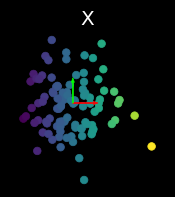

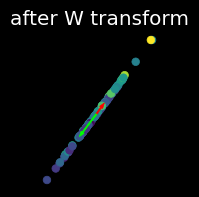

In [5]:
def show_data(X, colors, OI, title):
    show_scatterplot(X, colors, title=title)
    plot_bases(OI)

n_points = 100
X = torch.randn(n_points, 2, generator=g, device=device)
colors = X[:, 0]
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)
W = torch.randn(2, 2, generator=g, device=device) 

show_data(X, colors, OI, "X")
# transform points
Y = X @ W.t()
new_OI = OI @ W.t()
show_data(Y, colors, new_OI, "after W transform")


/var/folders/cw/rpsp488j51d92l0_8p2n5d9h0000gq/T/ipykernel_60891/391494336.py:2: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  U, S, V = torch.svd(W)


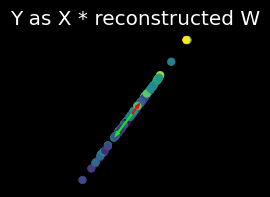

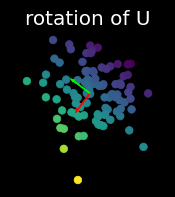

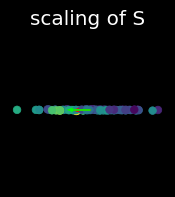

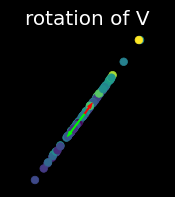

In [6]:
# compute singular values
U, S, V = torch.svd(W)
# reconstructed W
# reconstructed W
rW = (U @ torch.diag_embed(S)) @ V.t()
rY = X @ rW.t()
show_data(rY, colors, new_OI, "Y as X * reconstructed W")

#rY = X @ ((U @ torch.diag_embed(S)) @V.t()).t()

torch.testing.assert_close(W, rW, msg="W and reconstructed W should be real close")
torch.testing.assert_close(Y,rY, msg="Y and reconstructed Y from SVD should be really close")

# plot decomposition
YU = X@U
OIU = OI@U
show_data(YU, colors, OIU, "rotation of U")
    
# plot scaling
US = U @ torch.diag_embed(S)
#YS = YU @ torch.diag_embed(S)
YS = X @ US
#OIS = OIU @ torch.diag_embed(S)
OIS = OI @ US
show_data(YS, colors, OIS, "scaling of S")     

# last rotation
USV = US @ V.t()
torch.testing.assert_close(USV, rW, msg="stepped USV should be the same as reconstructed W")
#YV = (YS @ V.t())
YV = X @ USV.t()
torch.testing.assert_close(YV, rY, msg="stepped Y should be the same as reconstructed Y")
OIV = OI @ USV.t()
#OIV = OIS @ V.t()
show_data(YV, colors, OIV, "rotation of V")


## Non linear transformation

- Linear transforms can rotate, reflect, stretch and compress, but cannot curve
- Can (approximately) map points to a square by first stretching out by a factor s , then squashing with a tanh function

$$f(x)=tanh(\begin{bmatrix}s & 0 \\0 & s\end{bmatrix}X)$$

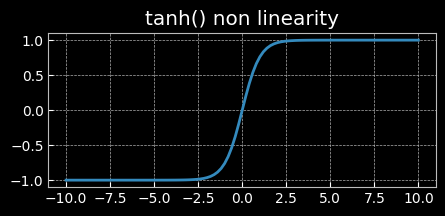

In [7]:
z = torch.linspace(-10, 10, 101)
s = torch.tanh(z)
plt.rc('figure', figsize=(5,2), dpi=dpi)
plot(z.numpy(), s.numpy())
title('tanh() non linearity');

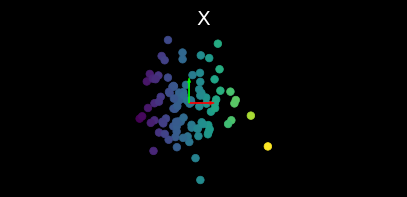

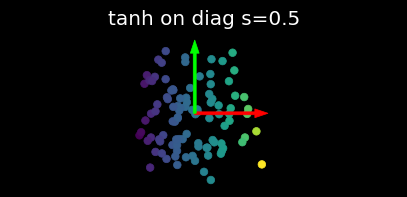

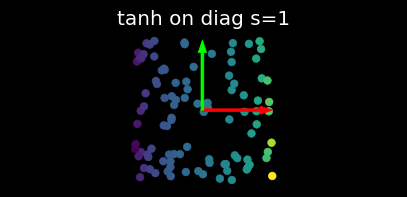

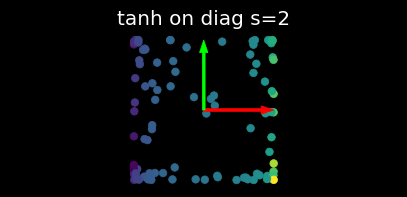

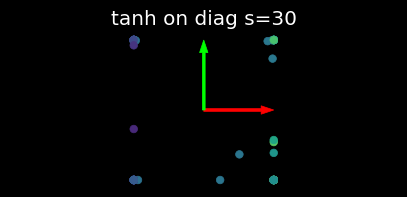

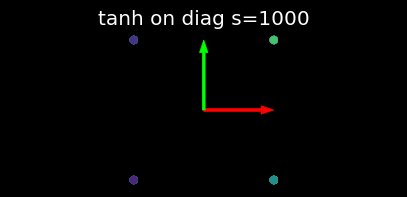

In [8]:
show_data(X,colors, OI, title="X")

#for s in range(1, 6):
def show_tanh(X, s):
    W= s*torch.eye(2, device=device)
    Y = torch.tanh(X @ W.t())
    show_data(Y,colors, OI, title=f"tanh on diag s={s}")

show_tanh(X,s=0.5)
show_tanh(X,s=1)
show_tanh(X,s=2)
show_tanh(X,s=30)
show_tanh(X,s=1000)




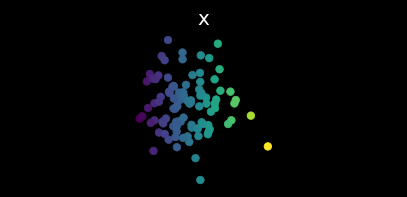

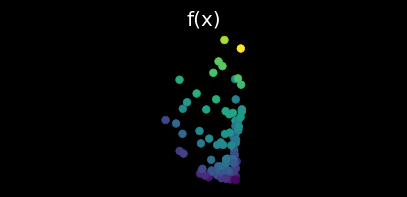

In [18]:
show_scatterplot(X, colors, title='x')
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()


# create 1-layer neural networks with random weights
model = nn.Sequential(
        nn.Linear(2, n_hidden), 
        NL,
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL,
        nn.Linear(n_hidden, 2)        
    )
model.to(device)
with torch.no_grad():
    Y = model(X)
show_scatterplot(Y, colors, title='f(x)')